# Geographical classification of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Employing language modelling and text classification to geolocate proverbs whose information is not known.
* Experimenting with 5 different train/test splits for statistical significance.
---


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import ast
!git clone https://github.com/ipavlopoulos/paremia.git

## Authorship analysis


In [132]:
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace', 'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia',  'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete', 'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor', 'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
regions = ['Πόντος', 'Κύπρος', 'Κάρπαθος', 'Θεσπρωτία', 'Αμοργός', 'Σκύρος', 'Μικρά Ασία', 'Λέσβος', 'Μακεδονία', 'Λακωνία', 'Εύβοια', 'Επτάνησος', 'Αρκαδία', 'Νάξος', 'Κρήτη', 'Αχαΐα', 'Θράκη', 'Ιωάννινα', 'Αιτωλία', 'Κεφαλληνία', 'Ανατολική Θράκη', 'Ρόδος', 'Ήπειρος']

class LinguisticOddity:
    
    def __init__(self, train, regions):
        # building the local language models
        self.models = {}
        self.regions = regions
        if self.regions == None:
            self.regions = train.area.unique()
        # creating a dictionary of language models, one per location
        for area in self.regions:
            texts = train[train.area==area].text.str.lower().values
            self.models[loc_name[area]] = LM(gram="CHAR").train(" \n ".join(texts))

    def ling_dist(self, proverb):
        '''
        Compute the bits per character (BPC) for a given proverb using many local language models
        Args:
            proverb (str): a text
        Returns:
            string: the location whose model predicts best the text 
            pd.DataFrame: BPC per location    
        '''
        entropy = {loc:[self.models[loc_name[loc]].cross_entropy(proverb.lower())] for loc in self.regions}
        likelier = loc_name[min(entropy, key=entropy.get)]
        return likelier, pd.DataFrame(entropy)

    def predict(self, texts):
        return [self.ling_dist(text)[0] for text in texts]

In [138]:
from lm.markov.models import LM

f_ones = []
for i in range(2,6):
    balanced_corpus = pd.read_csv(f"data/ssig/balanced_corpus_{i}.csv", index_col=0).reset_index()
    train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
    train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

    lo = LinguisticOddity(train=train, regions=regions)
    preds = lo.predict(test.text.values)
    gold = test.area.apply(lambda x: loc_name[x]).values
    f_ones.append(f1_score(gold, preds, zero_division=0, average=None, labels=[loc_name[r] for r in regions]))

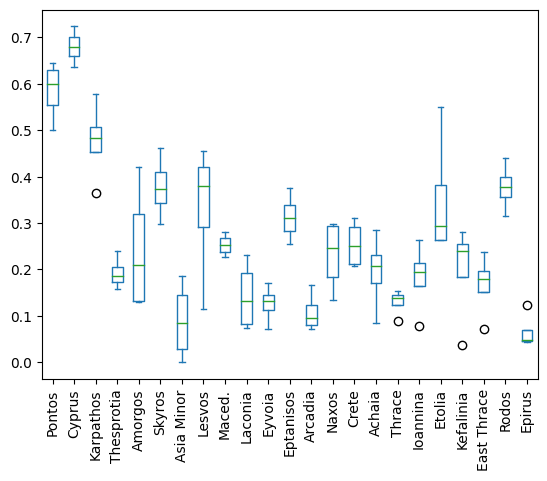

In [145]:
f_ones_pd = pd.DataFrame({f'r{i}':f_ones[i] for i in range(4)}, index=[loc_name[r] for r in regions])
f_ones_pd.T.plot.box(rot=90);

## Benchmarking standard text classifiers, on top of chanracter n-grams

In [15]:
vect = TfidfVectorizer(ngram_range=(2,5), # token sequences
                       analyzer="char", # tokens are characters
                       max_df=0.5, # ignore tokens present in more than 50% of the texts
                       min_df=2, # ignore tokens not present in at least two documents 
                       lowercase=True)
vect.fit(train.text.values)
print('Vocabulary:', len(vect.vocabulary_))
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}" \t(tfidf: {feat:.2f})')

Vocabulary: 81402
n-gram: "ία" 	(tfidf: 0.21)
n-gram: "αρ" 	(tfidf: 0.12)
n-gram: "αρο" 	(tfidf: 0.21)
n-gram: "αροι" 	(tfidf: 0.37)
n-gram: "ιμ" 	(tfidf: 0.19)
n-gram: "ιμί" 	(tfidf: 0.33)
n-gram: "ιμία" 	(tfidf: 0.38)
n-gram: "μί" 	(tfidf: 0.21)
n-gram: "μία" 	(tfidf: 0.30)
n-gram: "οι" 	(tfidf: 0.13)
n-gram: "οιμ" 	(tfidf: 0.28)
n-gram: "πα" 	(tfidf: 0.11)
n-gram: "παρ" 	(tfidf: 0.18)
n-gram: "παρο" 	(tfidf: 0.36)
n-gram: "ρο" 	(tfidf: 0.12)
n-gram: "ροι" 	(tfidf: 0.26)


In [157]:
f_scores = {'lr':[], 'rf':[], 'sv':[], 'nn':[]}
models = {'lr':None, 'rf':None, 'sv':None, 'nn':None}
for i in tqdm(range(2,6)):
    balanced_corpus = pd.read_csv(f"data/ssig/balanced_corpus_{i}.csv", index_col=0).reset_index()
    train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
    train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)
    vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=2, lowercase=True)
    vect.fit(train.text.values)

    # logistic regression
    lr = Pipeline([('vect', vect), ('ref', LogisticRegression())])
    lr.fit(train.text, train.area)
    models['lr']=lr

    # linear svc
    sv_best_params = {'C': 0.31193366798166167, 'penalty': 'l2', 'loss': 'hinge'}
    sv = Pipeline([('vect', vect), ('clf', LinearSVC(**sv_best_params, max_iter=5000))]) 
    sv.fit(train.text, train.area)
    models['sv']=sv
    
    # knn
    nn_best_params = {'n_neighbors': 50, 'weights': 'distance', 'p': 2}
    nn = Pipeline([('vect', vect), ('clf', KNeighborsClassifier(**nn_best_params))]) 
    nn.fit(train.text, train.area)
    models['nn'] = nn
    
    # forest
    rf_best_params = {'n_estimators': 329, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 1}
    rf = Pipeline([('vect', vect), ('clf', RandomForestClassifier(**rf_best_params))]) 
    rf.fit(train.text, train.area)
    models['rf'] = rf
    
    for model_name in models:
          m = models[model_name]
          f_scores[model_name].append(
              f1_score(test.area, # gold
                       m.predict(test.text), # predictions
                       zero_division=0, # some areas will be misclassified
                       average=None, # f1 per area
                       labels=regions) # we want the regions ranked
          )

  0%|          | 0/4 [00:00<?, ?it/s]

In [158]:
results = pd.DataFrame({m: np.array(f_scores[m]).mean(0) for m in models}, index=[loc_name[r] for r in regions])
results['aa'] = f_ones_pd.mean(1)
results

,lr,rf,sv,nn,aa
Pontos,0.542525,0.379641,0.518012,0.470900,0.585397
Cyprus,0.768220,0.626412,0.631518,0.612578,0.679686
Karpathos,0.426470,0.431911,0.506692,0.340325,0.476200
Thesprotia,0.219591,0.202919,0.208175,0.172148,0.192402
Amorgos,0.276146,0.232643,0.299345,0.207697,0.242283
Skyros,0.650055,0.546794,0.595670,0.533122,0.376965
Asia Minor,0.115054,0.028571,0.100338,0.079167,0.088554
Lesvos,0.401241,0.332299,0.401580,0.303468,0.331981
Maced.,0.162360,0.112195,0.266617,0.173200,0.252642
Laconia,0.112811,0.079313,0.136482,0.058349,0.142211
